# This notebook shows an example of calculating and visualizing the mean and variance from the latest USWC real time vector product from [HFRnet THREDDS server](http://hfrnet-tds.ucsd.edu/thredds/catalog.html)

Call %matplotlib inline to have plots shown inline in the notebook

%matplotlib inline must be called before any other packages are imported

In [1]:
%matplotlib inline

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs,feature

In [3]:
import xarray as xr
import datetime
import pandas as pd

### load 6km USWC RTV dataset through THREDDS <br>Some other datasets are shown as commented lines below
You must adjust your map parameters if you change regions

### instead of the NetCDF4 library, we will use xarray to read file from TDS


In [4]:
#USWC region
netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd')

#USEGC region
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd')
#netcdf_data = xr.open_dataset('http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/2km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_2km_Resolution_Hourly_RTV_best.ncd')

### list variables and dimensions

In [5]:
netcdf_data

<xarray.Dataset>
Dimensions:       (lat: 367, lon: 234, nProcParam: 7, nSites: 54, time: 61422)
Coordinates:
  * lat           (lat) float32 30.25 30.30394 30.35788 30.41182 30.46576 ...
  * lon           (lon) float32 -130.36 -130.29753 -130.23506 -130.1726 ...
  * time          (time) datetime64[ns] 2011-10-01 2011-10-01T01:00:00 ...
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRNet_1

### Show variable information

In [6]:
print(netcdf_data.u)
print(netcdf_data.v)
print(netcdf_data.time.max())


<xarray.DataArray 'u' (time: 61422, lat: 367, lon: 234)>
[5274798516 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 30.25 30.30394 30.35788 30.41182 30.46576 ...
  * lon       (lon) float32 -130.36 -130.29753 -130.23506 -130.1726 ...
  * time      (time) datetime64[ns] 2011-10-01 2011-10-01T01:00:00 ...
    time_run  (time) datetime64[ns] ...
Attributes:
    units:                m s-1
    long_name:            surface_eastward_sea_water_velocity
    standard_name:        surface_eastward_sea_water_velocity
    ancillary_variables:  DOPx
    _ChunkSizes:          [  1 367 234]
<xarray.DataArray 'v' (time: 61422, lat: 367, lon: 234)>
[5274798516 values with dtype=float32]
Coordinates:
  * lat       (lat) float32 30.25 30.30394 30.35788 30.41182 30.46576 ...
  * lon       (lon) float32 -130.36 -130.29753 -130.23506 -130.1726 ...
  * time      (time) datetime64[ns] 2011-10-01 2011-10-01T01:00:00 ...
    time_run  (time) datetime64[ns] ...
Attributes:
    units:       

### Grab lat, lon and time variables from dataset

In [7]:
lat=netcdf_data.lat
lon=netcdf_data.lon
time=netcdf_data.time

### Check time range of dataset

In [8]:
print("Dataset Start Time:",time.values.min())
print("Dataset End Time:",time.values.max())

Dataset Start Time: 2011-10-01T00:00:00.000000000
Dataset End Time: 2018-10-05T15:00:00.000000000


### Set a time range for analysis<br>Use 7 days from latest observation

In [9]:
timeEnd=time.max()
timeStart=timeEnd-np.timedelta64(7,'D')

print("Analysis Start Time:",timeStart.values)
print("Analysis End Time:",timeEnd.values)

Analysis Start Time: 2018-09-28T15:00:00.000000000
Analysis End Time: 2018-10-05T15:00:00.000000000


### Set geographical limits for the map

In [10]:
latMax=37.0
latMin=32.5
lonMax=-117.0
lonMin=-123.0

### subset data using slices of time, lat and lon <br> Show values of dimensions

In [11]:
data=netcdf_data.sel(time=slice(timeStart,timeEnd),lat=slice(latMin,latMax),lon=slice(lonMin,lonMax))
print(dict(data.dims))

{'lat': 84, 'lon': 96, 'nProcParam': 7, 'nSites': 54, 'time': 169}


### Do some clean up on the data<br>Interpolate in time<br> find the mean<br>subtract mean from data obs<br>create complex timeseries

In [12]:
# interpolate
data['uint']=data['u'].interpolate_na(dim='time')
data['vint']=data['v'].interpolate_na(dim='time')

In [13]:
# find the means along the time axis
data['u_mean']=data['u'].mean(dim='time')
data['v_mean']=data['v'].mean(dim='time')
data['u_dm']=data['uint']-data['u_mean']
data['v_dm']=data['uint']-data['v_mean']

In [ ]:
# demean data
def tmean(x):
    return (x-x.mean())
data_stacked=data.stack(geo=('lat','lon'))
data['udm']=data_stacked['uint'].groupby('geo').apply(tmean).unstack('geo')
data['vdm']=data_stacked['vint'].groupby('geo').apply(tmean).unstack('geo')

In [ ]:
# Create complex timeseries
data['uiv']=data['udm']+1j*data['vdm']

### Plot mean vectors

In [22]:
meanMag=np.sqrt(data['u_mean']**2+data['v_mean']**2)
meanDir=np.rad2deg(np.arctan2(data['v_mean'],data['u_mean']))

# lat and lon for plotting
lon,lat=np.meshgrid(data['lon'].values,data['lat'].values)

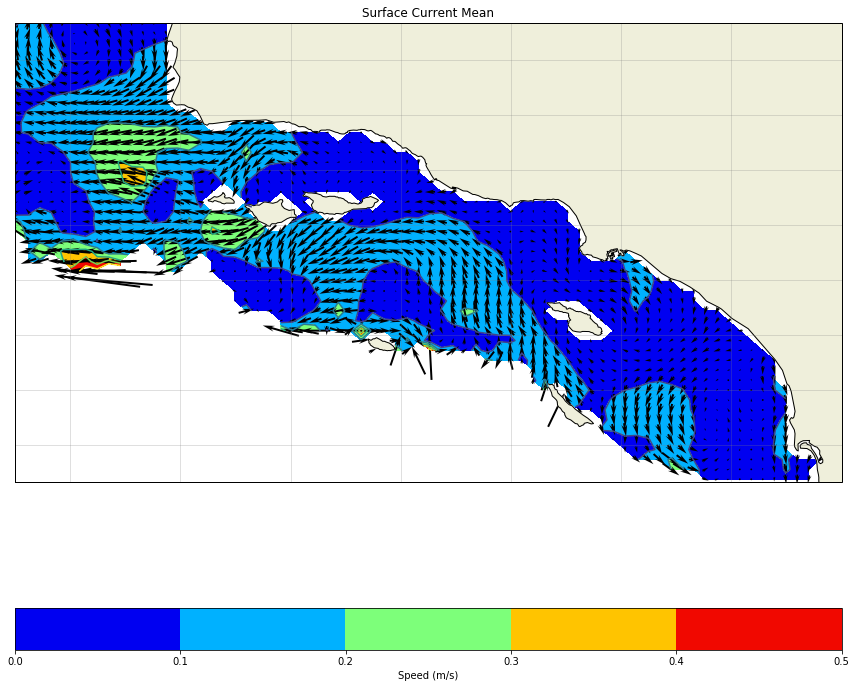

In [60]:
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection=crs.PlateCarree())
ax.gridlines(linewidth=.5, color='gray', alpha=0.5, linestyle='-')

ax.set_title('Surface Current Mean')
ax.set_extent([-121.5,-117,32.5,35])
CF=ax.contourf(lon,lat,meanMag,[0,.1,.2,.3,.4,.5],cmap='jet')
ax.contour(lon,lat,meanMag,[0,.1,.2,.3,.4,.5])
ax.quiver(lon,lat,data['u_mean'],data['v_mean'],headlength=6,headwidth=3,pivot='mid',scale=8)
ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor=feature.COLORS['land']))
plt.colorbar(CF,label="Speed (m/s)",orientation='horizontal')
ax.coastlines(resolution='10m',color='k')
plt.tight_layout()